# Using Neural Nets for Image Classification - MNIST

## What you will learn today
1.  Basics of backpropagation - mechanics of implementing gradient descent
2.  Network output layer architecture for multi-class classification
3.  Use of softmax and cross entropy functions
4.  Optimizing network performance

## Order of topics
1.  Back Propagation
2.  Description of MNIST data set
3.  Modifying earlier binary classification problem for multi-class problem
4.  Implementation and optimization of MNIST classifier.

## Pre Reading

https://en.wikipedia.org/wiki/MNIST_database

https://www.youtube.com/watch?v=S75EdAcXHKk - youtube video introducing some of the nets you'll see.

https://github.com/Newmu/Theano-Tutorials - This is the code from the video above.  The feed-forward code you'll see in class is adapted from the code in this github repo.

https://en.wikipedia.org/wiki/Softmax_function

http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.categorical_crossentropy

## What is Back Propagation?

Previous lectures have talked about using gradient descent to iteratively improve the weights in machine learning models (i.e. train the models).  With neural nets you will hear the terms "back propagation" used in conjunction with weight training.  Backpropagation is basically a bookeeping procedure for efficiently calculating the gradient of error in the network relative to the various weights involved in the neural network.  Backpropagation means calculating the gradient required for gradient descent.  Since you are using TensorFlow for this class, you won't really be required to grind out the details of doing the gradient calculations.  The TensorFlow.gradients() function will do that for you.  But you will be more comfortable using the system if you understand the basics of backpropagation.  Here is a simple illustration that you can generalize to more realistic cases if required.     

The figure below shows an extrememly simple neural network.  It's a three layer network with input, hidden and output layers.  It has a single neuron in each layer.  The activation functions at each layer and the function for measuring the error between prediction and true labels are left as general functions.  

http://colah.github.io/posts/2015-08-Backprop/ - Chris Olah's easy to understand explanation of backprop.  
https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ - Matt Mazur's simple example.  
https://emersion.fr/nnadl/chap2.html - Backpropagation chapter from Michael Nielson's book.  Derives matrix version of BP.  

<img src="files/simpleNN4BkProp.png">

Here are the definitions and equations that go along with the Figure above.  

$x, y$ - input and associated label

$w_i$ - weight on input

$a_h()$ - activation function in first hidden layer

$z_h$ - output of first hidden layer

$w_h$ - weight on hidden layer output

$a_o()$ - output layer activation function

$z_o$ - network output

$erf(z_o, y)$ - error/loss function for output and associated label

To perform gradient descent requires the derivatives of the output error with respect to the weight on the input and the weight on the hidden layer output.  What are the equations linking those?  

$z_h = a_h(w_ix)$

$z_o = a_o(w_hz_h)$

The steps through the network represent function composition that has a certain rythm - multiply by a weight, apply activation function, multiply by a weight, apply activation function, repeat.  The repetitions are function composition with the linear function (multiply by a weight) and function composition with the activation function.  Remember that taking the derivative of a composition of functions results in the products of the derivatives of the functions.  So

$\frac{derf}{dw_h} = \frac{derf}{dz_o}\frac{dz_o}{dw_h}$

$ = \frac{derf}{dz_o}\frac{da_o}{d.}z_h$

and look at the relationship between the expression for  $\frac{derf}{dw_h}$ and $\frac{derf}{dw_i}$.

$\frac{derf}{dw_i} = \frac{derf}{dz_o}\frac{da_o}{d.}\frac{dz_h}{dw_i}$

$= \frac{derf}{dz_o}\frac{da_o}{d.}\frac{da_h}{d.}x$

The expression for $\frac{derf}{dw_i}$ begins with the same terms as the expression for $\frac{derf}{dw_h}$.  So it makes sense to compute the derivatives starting at the output layer and working backwards through the network.  That saves recomputing the leading terms in the expression.  That's the essence of backpropagation, applying chain rule until you get to the layer you want.  

Q's
1.  Suppose that $a_o$ and $a_h$ are both sigmoid functions ($\frac{1}{(1 + e^{-x})}$)and that the error is the sum squared error.  Use the expressions above to derive the gradient descent equations.  Notice that "sum squared error" implies summing over all the training examples, whereas the equations above, give the gradient contribution from a single training example.

## MNIST Image Data Set
You will see a lot references to the MNIST image data set and you will see the data set used here as examples for image classification.  The MNIST data have played an important role in the progress of neural net technology and are still used as a standard against which new technologies are tested and benchmarked.  MNIST stands for mixed National Institute of Standards and Technology.  It consists of pixelated handwritten digits 0 - 9.  There are 60000 training examples and 10000 test examples.  Each example in the image data consists of 784 real numbers (28 x 28 pixel values) between 0.0 and 1.0 and a label (0 - 9).  The code below reads in the MNIST data and prints the 784 pixel values for the first example from the training set as a 28 x 28 image.  It also prints out the label in one-hot format and the maximum and minimum values from the first example.  The image shows grey-scale values where 1 gets mapped to white and 0 gets mapped to black.  

In [1]:
,
import numpy as np
import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h


def mnist(ntrain=60000, ntest=10000, onehot=True):
    fd = open('train-images.idx3-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28 * 28)).astype(float)
    
    fd = open('train-labels.idx1-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000))
    
    fd = open('t10k-images.idx3-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28 * 28)).astype(float)
    
    fd = open('t10k-labels.idx1-ubyte')
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX / 255.
    teX = teX / 255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]

    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX, teX, trY, teY

xTrain, xTest, yTrain, yTest = mnist()

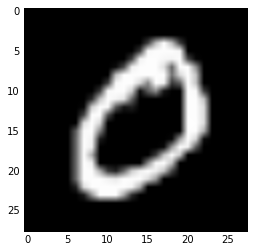

one-hot label =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
max value =  1.0   min value =  0.0


In [2]:
idx = 1
plt.imshow(xTrain[idx].reshape(28,28), cmap = cm.Greys_r)
plt.show()
print 'one-hot label = ', yTrain[idx]
print 'max value = ', max(xTrain[idx]), '  min value = ', min(xTrain[idx])

## Q's

1.  Pick some different index values in the training set and look at the character image and label to get a feel for the MNIST data set.
2.  Rewrite the code snip to select the test image data and labels and look at a few of those examples. 


## Using Simple two-layer ANN for Classifying MNIST Data
In an earlier lecture you saw a simple neural net used for two-class classification.  In this section, you will see very similar code used to classify the MNIST data.  Below is theano code for a two-layer fully connected network.  It consists of an input layer and an output layer.  Instead of a single output neuron like you saw in the two-class classifier, the MNIST classifier has 10 output neurons.  One neuron to predict each of the digits 0 - 9.  The code below implements sigmoid activation functions for these output neurons and then passes all 10 through a softmax function.  See the wikipedia page for a description of the softmax function.  

https://en.wikipedia.org/wiki/Softmax_function

The softmax function normalizes the values from the 10 output neurons so that they have the properties of a discrete probability distribution - they are all positive numbers and they sum to 1.  Softmax gives you the y-hat prediction probability for each class.  
Categorical cross entropy is then used to quantify the difference between predicted and actual values.  The one-hot coding for the labels turns the labels into a categorical probability density - one where all the probability mass is concentrated on the label value.  These two probabilities can be compared using cross entropy.  Here's a description of the cross-entropy function for making this comparison.  Cross entropy is the loss function for predictions where there are more than 2 classes.  

https://en.wikipedia.org/wiki/Cross_entropy

Notice that cross entropy is not a symmetric function of the two probability functions that go into the calculation.  Order matters in the arguments to the function.  

Realization of gradient descent has a couple of differences from the simple example introduced earlier.  One is that this realization does not wait to update the weights until it has run through all of the training examples.  Instead it performs weight updates on what are called "minibatchs" of 128 training examples.  That speeds up the training process.  The minibatch sizes may require some tuning.  Another difference in this realization, is that it is measuring misclassification error on test data - data that were not included in the training examples.  The printout of the training progress is tracking the percentage of examples that are correctly classified.  It's monitoring a different measure of system performance than is being used in the training.  That's because cross entropy is an analytic function that's differentiable and can be used for gradient descent, whereas misclassification error cannot.  On the other hand, misclassification error is a more intuitive measure of classification performance than cross entropy.    

## In-depth Explanation for the Code Below

2-layer fully connected neural net--not convolutional neural net:  

#### 1st layer:  
1st layer is the input X, which is a minibatch of pictures of numbers. Suppose each minibatch is 40, then the input X matrix shape is 40 by 784. Remember each picture is 28 by 28 pixels, so 784 pixels altogether. Basically, for each picture, flatten the array, so it is 1 by 784. Since you have 40 pictures in a minibatch, the feedforward input X matrix is 40 by 784. Since the first layer is just putting in the pictures,  there is no activation function.  

####  Between the 1st layer and 2nd layer
Multiply X by the weights matrix w. Weight matrix w has shape of 784 by 10 (7840 weights!). Each picture has 
784 pixels. There are 10 classes (numbers 0, 1, 2, 3, ..., 9). Hence, each column of weights in weight matrix w corresponds to each of the classes. For example, the first column of the matrix repesents the weights for 
classifying the picture as the number zero. The first column has 784 weights, a weight for each pixel of the picture saying how important that pixel is for identifying the image as a number zero.  

The input into the second layer is Xw, the shape is 40 by 10. Each row has 10 numbers, 1 for each of the 10 classes.  
Hypothetically, a row could look like this (though realistically, the numbers will be floats):
[1, 2, 1, 2, 8, 2, 4, 6, 4, 3]

#### 2nd layer  
The second layer applies the softmax activation. For each number in a row (of the input matrix), output a number such that the resulting row numbers add up to 1. Each row is the "probability" of the picture being that class. The output of the softmax is still 40 by 10.  
Hypothetically, an output row could look like this:  
[7.6e-04, 2.0e-03, 7.6e-04, 2.0e-03, 8.4e-01, 2.0e-03, 1.5e-02, 1.1e-01, 1.5e-02, 5.6e-03]  

#### Loss function  
Given the class probabilities, use cross entropy to determine how wrong the neural net is. Higher loss means that the neural net predicted the wrong class a lot. Low loss means that the neural net predicted the right class more often. However, even if the neural net predicted the right class every single time, the loss is still non-zero IF your softmax predictions are non-zero (which they most likely will be non-zero).  
Softmax output (probabilities of being in a certain class): [7.6e-04, 2.0e-03, 7.6e-04, 2.0e-03, 8.4e-01, 2.0e-03, 1.5e-02, 1.1e-01, 1.5e-02, 5.6e-03]    
Truth (what the class actually is): [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  
The neural net will properly classify the image has number 4 by taking the highest class. However, the other classes have non-zero probabilities, so the neural net is still a little wrong, so loss is non-zero.

For each image, you'll get a loss number (saying how wrong your prediction probabilities are). You'll get 40 by 1 matrix. Then, you take the mean of this matrix. For some images the predictions might be very wrong. If the neural net is any good, most images are predicted correctly. The mean accounts for these variations to get 1 scalar number--your loss value.  



##### Backpropogation  
Update your weight matrix until your prediction probabilities are good. Once you are satisfied that the loss function won't go down any further, then you save the weight matrix. Your weight matrix is your trained neural net. You can validate by putting in images from your testing set to see if the accuracy is high (i.e. 99% percent of the images are predicted to the correct class).   

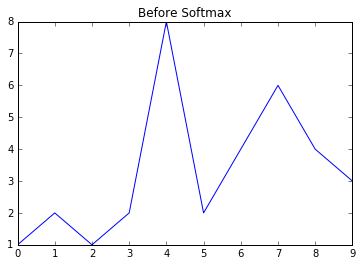

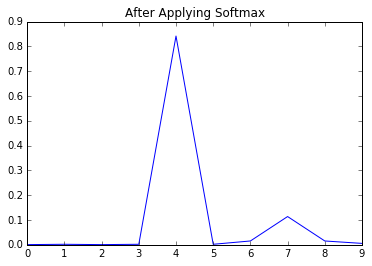

1.0


In [3]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

input_vector = [1, 2, 1, 2, 8, 2, 4, 6, 4, 3]
output_vector = softmax(input_vector)

plt.plot(input_vector)
plt.title("Before Softmax")
plt.show()
plt.plot(output_vector) 
plt.title("After Applying Softmax")
plt.show()
# notice what the softmax function does. It accentuates the class that's most
# likely (number 4) and reduces the other classes. It's like a max function
# but is softer in that if 2 classes are almost equally likely, then the softmax
# will keep these 2 classes at non-zero probabilities.

print sum(output_vector) # "probabilities" adds up to 1

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from mnistReader import mnist
from math import sqrt


xTrain, xTest, yTrain, yTest = mnist()

tf.reset_default_graph() 
g = tf.Graph() 
with g.as_default():
    
    X = tf.placeholder(tf.float32, shape=[None, 784]) # effectively the first layer; minibatch_size by 784 matrix
    Y = tf.placeholder(tf.float32, shape=[None, 10]) # true image class. this is a one-hot coded matrix, minibatch_size by 10

    lr = tf.constant(0.2, dtype=tf.float32, name='lr')
    weight_shape = [784, 10] # weight matrix shape for weight matrix between 1st and 2nd layer
    [n_inputs, n_outputs] = weight_shape
    init_range = sqrt(6.0 / (n_inputs + n_outputs))  #from glorot paper
    #Pick one of the following initializations for weights: idea is neural net to train faster
    w = tf.Variable(tf.random_normal(weight_shape, stddev=0.01), name='w')   #avant de -glorot
    #w = tf.Variable(tf.random_uniform(weight_shape, -init_range, init_range), name='w')   #apres glorot

    #define network
    logits = tf.matmul(X, w) # matrix multiplication between 1st and 2nd layer, minibatch_size by 10 matrix 
    py_x = tf.nn.softmax(logits) # this is second layer; minibatch_size by 10 matrix
    y_pred = tf.argmax(py_x, dimension=1) # predicting 1 class for each image, minibatch_size by 1 matrix

    #define cost
    rows_of_cost = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='rows_of_cost') # cost per image, minibatch_size by 1 matrix
    cost = tf.reduce_mean(rows_of_cost, reduction_indices=None, keep_dims=False, name='cost') # average cost over all images. actual loss value

    #extract gradients
    gradients = tf.gradients(cost, [w], name='gradients')[0] # wow! 1 line to get gradient wrt to complicated cost function

    #take training steps; backpropogation
    trainW = w.assign(w - lr * gradients)

    summary1 = tf.scalar_summary("Cost over time", cost) 
    summary2 = tf.histogram_summary('Weights over time', w)
    merged = tf.merge_summary([summary1, summary2]) 
    
    
with tf.Session(graph=g) as sess:
    sess.run(tf.initialize_all_variables())
    writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 40
    startEnd = zip(range(0, len(xTrain), miniBatchSize), range(miniBatchSize, len(xTrain) + 1, miniBatchSize))
    costList = []
    nPasses = 30
    iteration = 0
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            costVal, weight, tbSummary = sess.run([cost, trainW, merged], feed_dict={X: xTrain[s:e,], Y: yTrain[s:e]})
            # When trainW is called, it will return the updated weights
            writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(costVal)
        if iPass % 5 == 0: 
            testResult = sess.run([y_pred], feed_dict={X:xTest})
            print iPass, np.mean(np.argmax(yTest, axis=1) == testResult) #accuracy

0 0.908
5 0.9136
10 0.9143
15 0.9157
20 0.9166
25 0.917


cost history


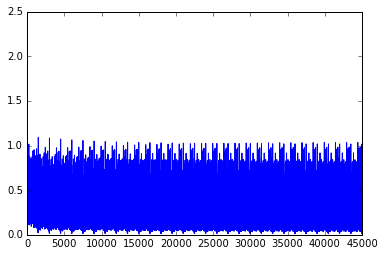

mean loss value: 0.271763682365


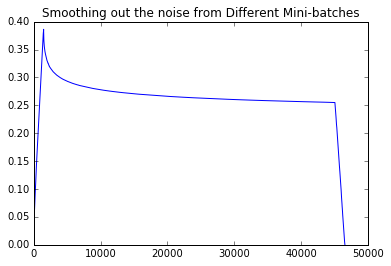

In [5]:
# Remember to open tensorboard, type: tensorboard --logdir=logs
# In Tensorboard, if it's got the orange tab but completely white underneath, 
# it's probably missing global.css file

#plot loss
xAxis = range(len(costList))
print 'cost history'
plt.plot(xAxis, costList)
plt.show()


# too much noise
print "mean loss value: {}". format(np.mean(costList))

width_of_conv = len(startEnd) # smoothing over different mini-batches
convo = np.ones((width_of_conv)) * 1.0 / width_of_conv
convOut = np.convolve(costList, convo)

plt.plot(convOut)
plt.title('Smoothing out the noise from Different Mini-batches')
plt.show() # loss really is decreasing

## Meta-parameter tweaking
1.  How many meta parameters can you find to tweak?  
2.  Divide up the class and try different tweaks in order to see what works the best.  
3.  Check the weight histograms to keep track of what they look like when they things aren't working

## Code mods
1.  Make lr a place holder so that you can pass lr from a feed dictionary during training.  
2.  Develop a training schedule for lr and program that into your net to see if you can get a performance improvement. 



## In-class coding Exercise

1. Implement AdaGrad in place of ordinary gradient descent.  How does that affect the training speed and achievable network performance?

For AdaGrad, AdaDelta, NAG methods you'll need to add some more variables to the update equation.  For example the update rule for AdaGrad at the $n^{th}$ step is:

$\Delta w_n = - \frac{\eta}{\sqrt{\sum_{i = 1}^{n} g_i^2}} g_n$

In this equation $\eta$ is a step size parameter that applies to all the elements of the gradient vector g.  Nothice that the sum of squared past gradients also adjusts the size of the gradient step making the steps smaller as the $g^2$ are accumulated.  But $g^2$ is a vector meaning that different components of the gradient g get different multipliers.  One view of this is that the components that are dominant at the beginning of training are incorporated and then those elements are suppressed allowing for smaller effects to be accumulated.

In order to use AdaGrad, you'll need to accumulate the sum of $g_n^2$.  To do that form a new variable - call it sumG, for example.  Then sumG has a tensorflow update that looks like

$sumG.assign(sumG + tf.square(g))$

This now delivers better numbers than plain gradient descent.  It required some adjustments in order to get performance.  One adjustment was starting the sumG with a small positive number instead of zeros.  The inversion seemed be causing the iteration to diverge.  Another possibility is that the weights aren't being initialized with the Glorot initialization and could be resulting in some saturation leading to very very small gradient values and correspondingly large inverses.  Try changing that to see if it leads to improvement.  

In [6]:
# copy code from above
# copy code from your old AdaGrad or AdaDelta in-class exercise

# Hint: If you are doing AdaGrad, g will be the same shape as the weight matrix.
# Hint: If you are doing AdaGrad, g is no longer shape (2, 1). Hence, you do 
# not need to perform tf.reshape
# Hint: In AdaGrad, there's a variable called g that needs to be updated, 
# but the TensorFlow is also called g (g = tf.Graph()). Just name one of them
# something else to avoid conflict.

## Discussion of training improvements in Glorot, Bengio paper

The paper that you saw in last lecture highlighted the problems of training multilayer networks and gave several recommendations describing how to avoid these problems.  

http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf

## Q's

1.  What does it mean to say that a neuron with sigmoid activation function is saturated?

2.  Which layers in a deep network are most prone to saturate?

3.  What properties of the weight initialization lead to saturation?

4.  What problems do the authors have with sigmoid non-linearity?